# Modelado Estocástico
## Ejemplo II.5.9a de Carol Alexander: Metodologia Engle-Granger

In [ ]:
# !pip install arch

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_coint_rank


In [ ]:
df = pd.read_csv('Examples9a.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,ftse100,sp500_usd,fx
0,1996-01-02,3687.9,620.73,0.642467
1,1996-01-03,3715.6,621.32,0.644454
2,1996-01-04,3714.1,617.70,0.646705
3,1996-01-05,3704.5,616.71,0.644330
4,1996-01-08,3720.6,618.46,0.645369


In [ ]:
df['sp500_p'] = df['sp500_usd'] * df['fx']
ctes = df.loc[0]

df['sp500_p2'] = df['sp500_p'] * 100/ ctes['sp500_p']
df['ftse100_p'] = df['ftse100']*100/ctes['ftse100']
df['sp500_usd2'] = df['sp500_usd'] *100 /ctes['sp500_usd']

df

,date,ftse100,sp500_usd,fx,sp500_p,sp500_p2,ftse100_p,sp500_usd2
0,1996-01-02,3687.9,620.73,0.642467,398.798587,100.000000,100.000000,100.000000
1,1996-01-03,3715.6,621.32,0.644454,400.412451,100.404682,100.751105,100.095049
2,1996-01-04,3714.1,617.70,0.646705,399.469702,100.168284,100.710431,99.511865
3,1996-01-05,3704.5,616.71,0.644330,397.364691,99.640446,100.450121,99.352375
4,1996-01-08,3720.6,618.46,0.645369,399.135205,100.084408,100.886683,99.634302
...,...,...,...,...,...,...,...,...
2731,2007-02-26,6434.7,1449.37,0.509398,738.306760,185.132742,174.481412,233.494434
2732,2007-02-27,6286.1,1399.04,0.508621,711.581303,178.431250,170.452019,225.386239
2733,2007-02-28,6171.5,1406.82,0.509866,717.289553,179.862612,167.344559,226.639602
2734,2007-03-01,6116.0,1403.17,0.510751,716.670923,179.707488,165.839638,226.051584


Regresión OLS

In [ ]:
y = df['ftse100_p']
X = sm.add_constant(df['sp500_p2'])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ftse100_p   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     8009.
Date:                Sat, 16 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:35:03   Log-Likelihood:                -10722.
No. Observations:                2736   AIC:                         2.145e+04
Df Residuals:                    2734   BIC:                         2.146e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.9248      1.109     38.709      0.0

In [ ]:
resid = model.resid
df['residuals'] = resid
resid

,0
0,0.041547
1,0.561847
2,0.656000
3,0.696734
4,0.880089
...,...
2731,25.968650
2732,25.761362
2733,21.837544
2734,20.421095


Recreamos los gráficos de los ejemplos del libro

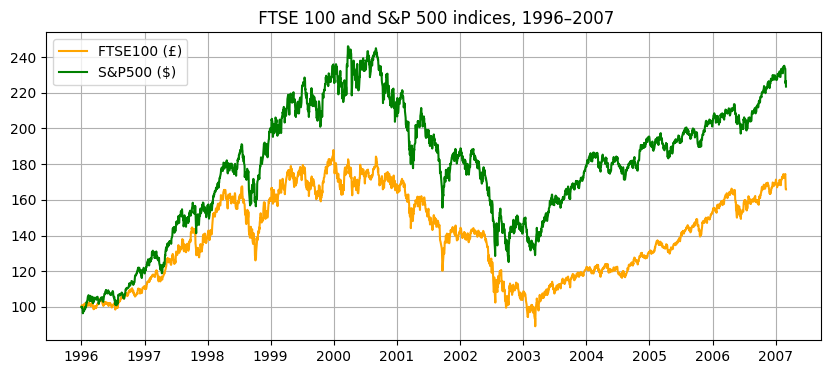

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['date'],df["ftse100_p"], label="FTSE100 (£)", color='orange')
plt.plot(df['date'],df["sp500_usd2"], label="S&P500 ($)", color='green')

plt.title(" FTSE 100 and S&P 500 indices, 1996–2007")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

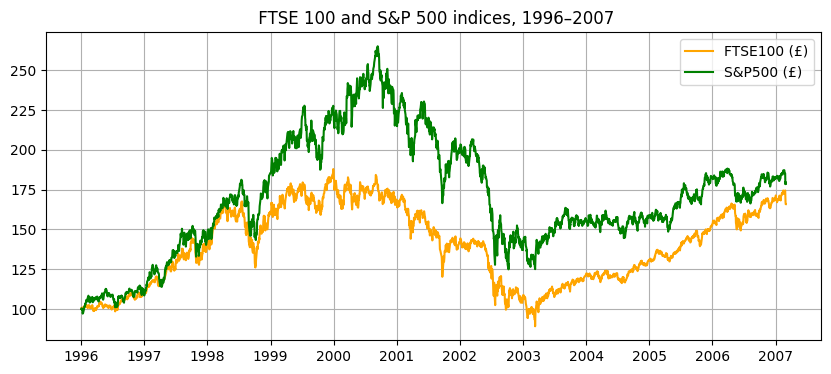

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['date'],df["ftse100_p"], label="FTSE100 (£)", color='orange')
plt.plot(df['date'],df["sp500_p2"], label="S&P500 (£)", color='green')

plt.title(" FTSE 100 and S&P 500 indices, 1996–2007")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

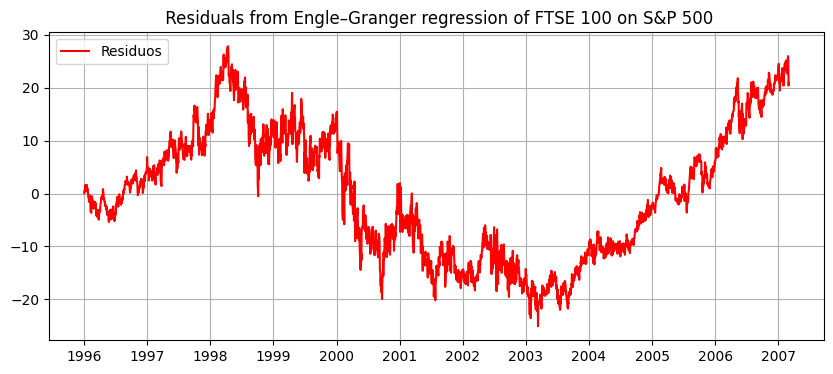

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['date'],resid, label="Residuos", color='red')

plt.title(" Residuals from Engle–Granger regression of FTSE 100 on S&P 500")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

Coincidente con el libro, vemos el alto grado de autocorrelación en los residuos. Y podemos calcular también el promedio que, al tratarse de una regresión OLS será 0.

In [ ]:
resid.mean()

np.float64(-1.1302200241330248e-14)

La prueba ADF(2) sobre los residuos arroja un estadístico ADF(2) estimado de -1,86, que no es lo suficientemente grande como para rechazar la hipótesis nula de que los residuos son no estacionarios. Por lo tanto, los índices FTSE 100 y S&P 500 no están cointegrados.

In [ ]:
adf_res = adfuller(resid, maxlag=2, regression='n')
print(f"ADF(2) statistic: {adf_res[0]:.3f}")
print(f"p-value: {adf_res[1]:.4f}")
print(f"Lags used: {adf_res[2]}")

ADF(2) statistic: -1.865
p-value: 0.0592
Lags used: 2
